# Forward dynamics of infection on Zachary’s karate club data
Comparison with Fig. 2 in *Ortega et. al*, [Dynamics of epidemics from cavity master equations: Susceptible-infectious-susceptible models](https://doi.org/10.1103/PhysRevE.105.024308)

In [2]:
using MatrixProductBP, MatrixProductBP.Models
using IndexedGraphs, DelimitedFiles, Plots, Statistics, LaTeXStrings, Random
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear)
import Measurements: value, ±
using Graphs
using JLD2;

In [3]:
# read matrix of contacts, found at http://konect.cc/networks/ucidata-zachary/
A = readdlm("karate.txt", Bool)
g = IndexedGraph(A);

### MPBP

In [142]:
N = nv(g)  # number of individuals
T = 50     # final time
ΔT = 1.0   # discretization
λ = 0.1    # prob. of transmission
ρ = 0.05   # prob. of recovery

# adjust probabilities and number of discrete time steps to simulate continuous-time behavior
sis = SIS(g, λ*ΔT, ρ*ΔT, floor(Int, T/ΔT))

# prob. of being infected at time zero
# γ = fill(3/N, N)
γ = [i==1 ? 1.0 : 0.0 for i in 1:N]
for i in 1:N
    sis.ϕ[i][1] .= [1-γ[i], γ[i]]
end

# set up MPBP computation
bp = mpbp(sis)
cb = CB_BP(bp);

In [143]:
k = 10
svd_trunc = TruncBond(k)   # maximum matrix size for SVD-based truncation
maxiter = 100
tol = 1e-6

# run MPBP
reset!(bp)
iters, cb = iterate!(bp; cb, svd_trunc, maxiter, tol);

Running MPBP: iter 11 	 Time: 0:30:17
  Δ:                6.878124123588236e-7
  SVD Matrix size:  10

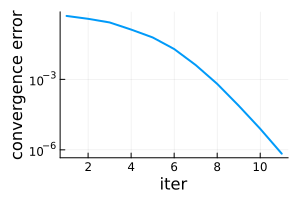

In [144]:
plot(cb.Δs, ylabel="convergence error", xlabel="iter", yaxis=:log10, 
    size=(300,200), label="")

In [145]:
# compute marginals
b_bp = beliefs(bp)
p_bp = [[bb[INFECTED] for bb in b] for b in b_bp];

### SoftMargin MonteCarlo

In [146]:
# instantiate Soft Margin sampler
sms = SoftMarginSampler(bp);

In [147]:
# draw samples
# re-run this cell (but not the one above!) to draw more samples and refine the estimate
rng = MersenneTwister(1)
nsamples_mc = 2*10^5
sample!(sms, nsamples_mc; rng);

SoftMargin sampling 100%|████████████████████████████████| Time: 0:02:4739m


In [148]:
b_mc = marginals(sms)
p_mc = [[value(bb[INFECTED]/sum(bb)) for bb in b] for b in b_mc];

Marginals from Soft Margin 100%|█████████████████████████| Time: 0:00:26


In [149]:
# estimate probability of epidemic to die out at time `Tdead`
Tdead = T
ids = findall(!all(x[:,Tdead] .== SUSCEPTIBLE) for x in sms.X)
p_dead_epidemic_mc = 1 - sum(sms.w[ids]) / sum(sms.w)
println("Probability of epidemic being wiped out by time $Tdead (MC estimate): ", 
    p_dead_epidemic_mc)

# discard samples where the epidemic was dead by time `Tdead`
Xnew = sms.X[ids]
wnew = sms.w[ids]
sms_new = SoftMarginSampler(bp, Xnew, wnew)
b_mc_trimmed = marginals(sms_new)
p_mc_trimmed = [[value(bb[INFECTED]/sum(bb)) for bb in b] for b in b_mc_trimmed];

Probability of epidemic being wiped out by time 50 (MC estimate): 0.014735000000000054


Marginals from Soft Margin 100%|█████████████████████████| Time: 0:00:26


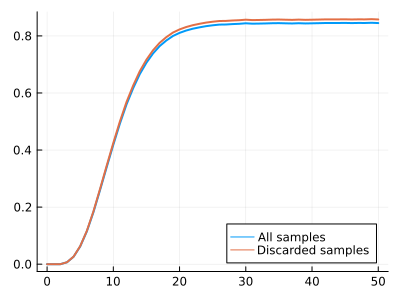

In [150]:
i = 30
plot(0:ΔT:T, value.(p_mc[i]), label="All samples")
plot!(0:ΔT:T, value.(p_mc_trimmed[i]), label="Discarded samples", legend=:bottomright, size=(400,300))

### Discretized mean field methods

In [151]:
Tdisc = floor(Int, T/ΔT)
ϕ = [zeros(ne(bp.g)) for t in 0:Tdisc]
r = [zeros(nv(bp.g)) for t in 0:Tdisc]
r[1] .= γ
for (i,j,id) in edges(g)
    ϕ[1][id] = r[1][i]*(1-r[1][j])
end

# dynamic message passing
function dmp_disc!(r, ϕ, Tdisc, g, λ, ρ)
    ProgressMeter.@showprogress for t in 2:Tdisc+1
        for i in vertices(g)
           r[t][i] = (1-ρ)*r[t-1][i] + 
                (1-prod(1-λ*ϕ[t-1][idx(e)] for e in inedges(g, i); init=1.0))*(1-r[t-1][i])
        end
        for (i, j, id) in edges(g)
           ϕ[t][id] = (1-ρ)*ϕ[t-1][id] + 
                (1-ϕ[t-1][id])*(1-prod(1-λ*ϕ[t-1][idx(e)] for e in inedges(g, i) if src(e)!=j; init=1.0))
        end
    end
    nothing
end
                
# discretized mean field
function ibmf_disc!(r, Tdisc, g, λ, ρ)
    ProgressMeter.@showprogress for t in 2:Tdisc+1
        for i in vertices(g)
           r[t][i] = (1-ρ)*r[t-1][i] + 
                (1-r[t-1][i])*(1-prod(1-λ*r[t-1][j] for j in inneighbors(g, i); init=1.0))
        end
    end
    nothing
end
                
dmp_disc!(r, ϕ, Tdisc, bp.g, λ*ΔT, ρ*ΔT)
p_dmp_disc = [[r[t][i] for t in eachindex(r)] for i in 1:N]
                
r = [zeros(nv(bp.g)) for t in 0:Tdisc]
r[1] .= γ
ibmf_disc!(r, Tdisc, bp.g, λ*ΔT, ρ*ΔT)
p_ibmf_disc = [[r[t][i] for t in eachindex(r)] for i in 1:N];

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


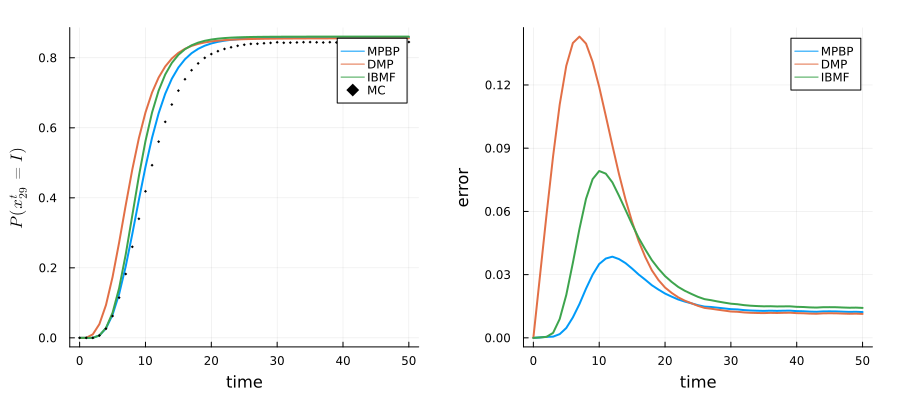

In [153]:
Plots.default(lw=2)
i = 30

pl = plot(xlabel="time", xticks=0:10:T, ylabel=L"P(x_{29}^t=I)", legend=:topright)
plot!(pl, 0:ΔT:T, p_bp[i], label="MPBP")
plot!(pl, 0:ΔT:T, p_dmp_disc[i], label="DMP")
plot!(pl, 0:ΔT:T, p_ibmf_disc[i], label="IBMF")
scatter!(pl, 0:ΔT:T, value.(p_mc[i]), c=:black, m=:diamond, ms=1.5, label="MC")

err_bp = [mean(abs(p_bp[i][t]-p_mc[i][t]) for i in 1:N) for t in 1:T+1]
err_dmp_disc = [mean(abs(p_dmp_disc[i][t]-p_mc[i][t]) for i in 1:N) for t in 1:T+1]
err_ibmf_disc = [mean(abs(p_ibmf_disc[i][t]-p_mc[i][t]) for i in 1:N) for t in 1:T+1]
pl_err = plot(xlabel="time", ylabel="error", xticks=0:10:T)
plot!(pl_err, 0:ΔT:T, err_bp, label="MPBP")
plot!(pl_err, 0:ΔT:T, err_dmp_disc, label="DMP")
plot!(pl_err, 0:ΔT:T, err_ibmf_disc, label="IBMF")

plot(pl, pl_err, size=(900,400), margin=5Plots.mm)

In [123]:
savefig("discrete_allsamples.pdf")

"/home/crotti/MatrixProductBP/notebooks/discrete_allsamples.pdf"

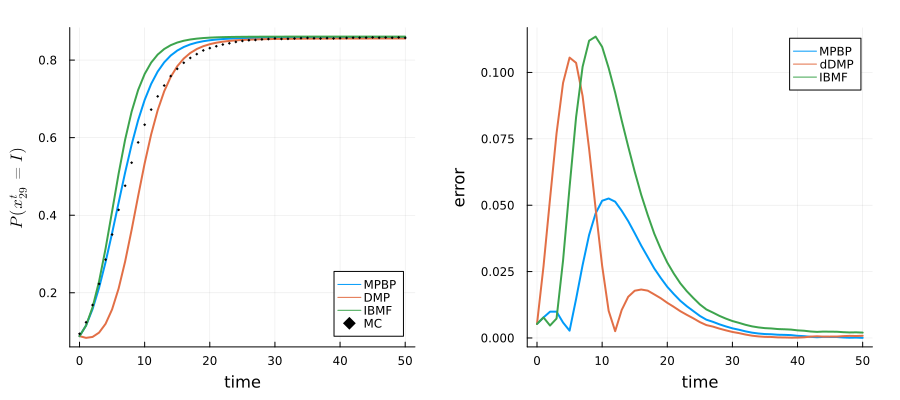

In [138]:
Plots.default(lw=2)
i = 30

pl = plot(xlabel="time", xticks=0:10:T, ylabel=L"P(x_{29}^t=I)", legend=:bottomright)
plot!(pl, 0:ΔT:T, p_bp[i], label="MPBP")
plot!(pl, 0:ΔT:T, p_dmp_disc[i], label="DMP")
plot!(pl, 0:ΔT:T, p_ibmf_disc[i], label="IBMF")
scatter!(pl, 0:ΔT:T, value.(p_mc_trimmed[i]), c=:black, m=:diamond, ms=1.5, label="MC")

err_bp = mean(p_bp .- p_mc_trimmed) .|> value .|> abs
err_dmp_disc = mean(p_dmp_disc .- p_mc_trimmed) .|> value .|> abs
err_ibmf_disc = mean(p_ibmf_disc .- p_mc_trimmed) .|> value .|> abs
pl_err = plot(xlabel="time", ylabel="error", xticks=0:10:T)
plot!(pl_err, 0:ΔT:T, err_bp, label="MPBP")
plot!(pl_err, 0:ΔT:T, err_dmp_disc, label="dDMP")
plot!(pl_err, 0:ΔT:T, err_ibmf_disc, label="IBMF")

plot(pl, pl_err, size=(900,400), margin=5Plots.mm)

### Other methods

In [154]:
# cavity master equation
function cme!(r, ϕ, Tdisc, g, λ, ρ)
    ProgressMeter.@showprogress for t in 2:Tdisc+1
        for i in vertices(g)
           r[t][i] = (1-ρ)*r[t-1][i] + λ*(1-r[t-1][i])*sum(ϕ[t-1][idx(e)] for e in inedges(g, i); init=0.0)
        end
        for (i, j, id) in edges(g)
           ϕ[t][id] = (1-ρ)*ϕ[t-1][id] + 
                (1-ϕ[t-1][id])*λ*sum(ϕ[t-1][idx(e)] for e in inedges(g, i) if src(e)!=j; init=0.0)
        end
    end
    nothing
end

# dynamic message passing
function dmp!(r, ϕ, Tdisc, g, λ, ρ)
    ProgressMeter.@showprogress for t in 2:Tdisc+1
        for i in vertices(g)
           r[t][i] = (1-ρ)*r[t-1][i] + λ*(1-r[t-1][i])sum(ϕ[t-1][idx(e)] for e in inedges(g, i); init=0.0)
        end
        for (i, j, id) in edges(g)
           ϕ[t][id] = (1-ρ)*ϕ[t-1][id] + 
                (1-r[t-1][i])*λ*sum(ϕ[t-1][idx(e)] for e in inedges(g, i) if src(e)!=j; init=0.0)
        end
    end
    nothing
end

# individual based mean field
function ibmf!(r, Tdisc, g, λ, ρ)
    ProgressMeter.@showprogress for t in 2:Tdisc+1
        for i in vertices(g)
           r[t][i] = (1-ρ)*r[t-1][i] + λ*(1-r[t-1][i])sum(r[t-1][src(e)] for e in inedges(g, i); init=0.0)
        end
    end
    nothing
end

ibmf! (generic function with 1 method)

In [155]:
Δt = 1e-4
nT = 200  # number of time steps to be saved
Δtplot = T/nT
Tdisc = floor(Int, T/Δt)

ϕ = [zeros(ne(bp.g)) for t in 0:Tdisc]
r = [zeros(nv(bp.g)) for t in 0:Tdisc]

r[1] .= γ

for (i,j,id) in edges(g)
    ϕ[1][id] = r[1][i]*(1-r[1][j])
end

In [156]:
r_cme = deepcopy(r)
ϕ_cme = deepcopy(ϕ)
cme!(r_cme, ϕ_cme, Tdisc, bp.g, λ*Δt, ρ*Δt)
p_cme = [[rt[i] for rt in r_cme[1:Int(Tdisc/nT):end]] for i in 1:N];

Progress: 100%|█████████████████████████████████████████| Time: 0:00:20


In [157]:
r_dmp = deepcopy(r)
ϕ_dmp = deepcopy(ϕ)
dmp!(r_dmp, ϕ_dmp, Tdisc, bp.g, λ*Δt, ρ*Δt)
p_dmp = [[rt[i] for rt in r_dmp[1:Int(Tdisc/nT):end]] for i in 1:N];

Progress: 100%|█████████████████████████████████████████| Time: 0:00:21


In [158]:
r_ibmf = deepcopy(r)
ibmf!(r_ibmf, Tdisc, bp.g, λ*Δt, ρ*Δt)
p_ibmf = [[rt[i] for rt in r_ibmf[1:Int(Tdisc/nT):end]] for i in 1:N];

Progress: 100%|█████████████████████████████████████████| Time: 0:00:17


### Continuous MonteCarlo (Gillespie-like)

In [159]:
p_gill,_ = continuous_sis_sampler(sis, T, λ, ρ; nsamples = 10^5, sites=1:N, Δt=Δtplot,
    discard_dead_epidemics=false)
p_gill_trimmed,_ = continuous_sis_sampler(sis, T, λ, ρ; nsamples = 10^5, sites=1:N, Δt=Δtplot,
    discard_dead_epidemics=true);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
Progress: 100%|█████████████████████████████████████████| Time: 0:00:15


### MPBP with smaller $\Delta T$

In [160]:
# ΔT2 = ΔT   # discretization
# sis = SIS(g, λ*ΔT2, ρ*ΔT2, floor(Int, T/ΔT2))

# # prob. of being infected at time zero
# for i in 1:N
#    if i == 1
#         sis.ϕ[i][1] .= [0.0, 1.0]   # node 1 is infected at time zero
#     else
#         sis.ϕ[i][1] .= [1.0, 0.0]   # all other nodes start as susceptible
#     end
# end

# # set up MPBP computation
# bp2 = mpbp(sis)
# cb2 = CB_BP(bp2);

In [161]:
# k2 = 6
# svd_trunc = TruncBond(k2)   # maximum matrix size for SVD-based truncation
# maxiter = 100
# tol = 1e-4

# # run MPBP
# reset!(bp2)
# iters, cb2 = iterate!(bp2; cb=cb2, svd_trunc, maxiter, tol);

In [162]:
# plot(cb2.Δs, ylabel="convergence error", xlabel="iter", yaxis=:log10, 
#     size=(300,200), label="")

In [163]:
# # compute marginals
# b_bp2 = beliefs(bp2)
# p_bp2 = [[bb[INFECTED] for bb in b] for b in b_bp2];

### Plots

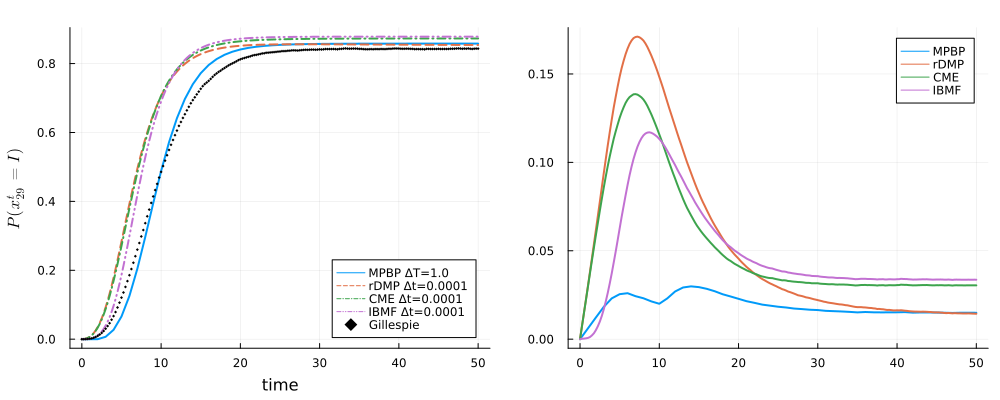

In [164]:
Plots.default(lw=2)
i = 30

pl = plot(xlabel="time", xticks=0:10:T, ylabel=L"P(x_{29}^t=I)", legend=:bottomright)
plot!(pl, 0:ΔT:T, p_bp[i], label="MPBP ΔT=$(ΔT)")
plot!(pl, 0:Δtplot:T, p_dmp[i], ls=:dash, label="rDMP Δt=$(Δt)")
plot!(pl, 0:Δtplot:T, p_cme[i], ls=:dashdot, label="CME Δt=$(Δt)")
plot!(pl, 0:Δtplot:T, p_ibmf[i], ls=:dashdotdot, label="IBMF Δt=$(Δt)")

plot!(pl, 0:Δtplot:T, p_gill[i], label="Gillespie", m=:diamond, st=:scatter, ms=1.5,
    c=:black, msc=:auto)
plot!(pl, size=(1000,400), margin=5Plots.mm, legend=:bottomright)

err_bp = [mean(abs(p_bp[i][t]-p_gill[i][1:floor(Int, ΔT/Δtplot):end][t]) for i in 1:N) for t in eachindex(p_bp[1])]
err_dmp = [mean(abs(p_dmp[i][t]-p_gill[i][t]) for i in 1:N) for t in eachindex(p_gill[1])]
err_cme = [mean(abs(p_cme[i][t]-p_gill[i][t]) for i in 1:N) for t in eachindex(p_gill[1])]
err_ibmf = [mean(abs(p_ibmf[i][t]-p_gill[i][t]) for i in 1:N) for t in eachindex(p_gill[1])]

pl_err = plot(0:ΔT:T, err_bp, label="MPBP")
plot!(pl_err, 0:Δtplot:T, err_dmp, label="rDMP")
plot!(pl_err, 0:Δtplot:T, err_cme, label="CME")
plot!(pl_err, 0:Δtplot:T, err_ibmf, label="IBMF")

plot(pl, pl_err)

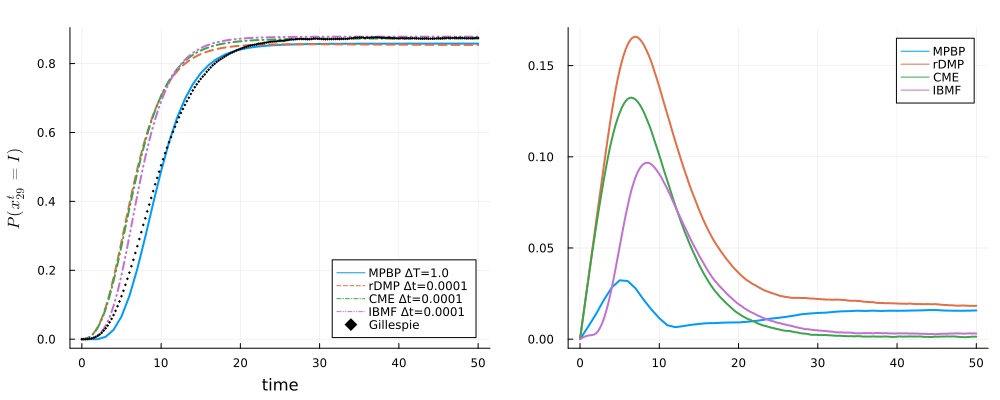

In [165]:
Plots.default(lw=2)
i = 30

pl = plot(xlabel="time", xticks=0:10:T, ylabel=L"P(x_{29}^t=I)", legend=:bottomright)
plot!(pl, 0:ΔT:T, p_bp[i], label="MPBP ΔT=$(ΔT)")
plot!(pl, 0:Δtplot:T, p_dmp[i], ls=:dash, label="rDMP Δt=$(Δt)")
plot!(pl, 0:Δtplot:T, p_cme[i], ls=:dashdot, label="CME Δt=$(Δt)")
plot!(pl, 0:Δtplot:T, p_ibmf[i], ls=:dashdotdot, label="IBMF Δt=$(Δt)")

plot!(pl, 0:Δtplot:T, p_gill_trimmed[i], label="Gillespie", m=:diamond, st=:scatter, ms=1.5, msc=:auto, c=:black)
plot!(pl, size=(1000,400), margin=5Plots.mm, legend=:bottomright)

err_bp_trimmed = [mean(abs(p_bp[i][t]-p_gill_trimmed[i][1:floor(Int, ΔT/Δtplot):end][t]) for i in 1:N) for t in eachindex(p_bp[1])]
err_dmp_trimmed = [mean(abs(p_dmp[i][t]-p_gill_trimmed[i][t]) for i in 1:N) for t in eachindex(p_gill_trimmed[1])]
err_cme_trimmed = [mean(abs(p_cme[i][t]-p_gill_trimmed[i][t]) for i in 1:N) for t in eachindex(p_gill_trimmed[1])]
err_ibmf_trimmed = [mean(abs(p_ibmf[i][t]-p_gill_trimmed[i][t]) for i in 1:N) for t in eachindex(p_gill_trimmed[1])]

pl_err = plot(0:ΔT:T, err_bp_trimmed, label="MPBP")
plot!(pl_err, 0:Δtplot:T, err_dmp_trimmed, label="rDMP")
plot!(pl_err, 0:Δtplot:T, err_cme_trimmed, label="CME")
plot!(pl_err, 0:Δtplot:T, err_ibmf_trimmed, label="IBMF")

plot(pl, pl_err)

In [166]:
c_bp = autocovariances(bp);

In [34]:
include("../../telegram/notifications.jl");
@telegram "karate"

In [169]:
jldsave("plot_data/sis_karate_club_network.jld2"; T, ΔT, Δt, b_bp, p_bp, p_mc, 
    p_dmp_disc, p_ibmf_disc, p_dmp, p_cme, p_ibmf, p_gill, nT, c_bp, λ, ρ, svd_trunc);